<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Basic-Features" data-toc-modified-id="Basic-Features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic Features</a></span></li><li><span><a href="#Count-Features" data-toc-modified-id="Count-Features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Count Features</a></span></li><li><span><a href="#One-Hot-Encoding" data-toc-modified-id="One-Hot-Encoding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>One Hot Encoding</a></span></li><li><span><a href="#Capturing-Feature-Interactions" data-toc-modified-id="Capturing-Feature-Interactions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Capturing Feature Interactions</a></span></li><li><span><a href="#Cross-Validation-(10-Folds)" data-toc-modified-id="Cross-Validation-(10-Folds)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Cross Validation (10 Folds)</a></span></li></ul></div>

In [1]:
import gc
import pandas as pd
import numpy as np
from itertools import combinations
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import OneHotEncoder

pd.set_option("max_columns", 500)
pd.set_option("max_rows", 500)

In [2]:
test = pd.read_csv("../Data_Test.csv")
train = pd.read_csv("../Data_Train.csv")
train.shape, test.shape

((78458, 11), (19615, 10))

### Data Preprocessing

In [3]:
# function to convert popularity and likes to integer
def convert_str_to_count(value):
    #     value = str(value)
    value = value.replace(',', '')

    if value[-1] == 'K':
        value = float(value[:-1])*10**3
    elif value[-1] == 'M':
        value = float(value[:-1])*10**6
    else:
        value = float(value)

    return value


train['Popularity'] = train['Popularity'].map(convert_str_to_count)
train['Likes'] = train['Likes'].map(convert_str_to_count)

### Basic Features

In [4]:
test['Popularity'] = test['Popularity'].map(convert_str_to_count)
test['Likes'] = test['Likes'].map(convert_str_to_count)

train['Followers'] = train['Followers'].astype('float')
test['Followers'] = test['Followers'].astype('float')

train['Popularity'] = train['Popularity'].astype('float')
test['Popularity'] = test['Popularity'].astype('float')

train['Comments'] = train['Comments'].astype('float')
test['Comments'] = test['Comments'].astype('float')

from datetime import datetime
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
test['Timestamp'] = pd.to_datetime(test['Timestamp'])

# train['Song_Age'] = 2020 - train['Timestamp'].dt.year
# test['Song_Age'] = 2020 - test['Timestamp'].dt.year

current_time = datetime.now()
train['Song_Age'] = (current_time - train['Timestamp']).dt.days
test['Song_Age'] = (current_time - test['Timestamp']).dt.days

train['Song_Age_Rev'] = 1/train['Song_Age']
test['Song_Age_Rev'] = 1/test['Song_Age']

### Count Features

In [5]:
test['Views'] = -99

overall = pd.concat((train, test), axis=0, sort=False, ignore_index=True)

name_count = overall['Name'].value_counts()
train['Name_Count'] = train['Name'].map(name_count)
test['Name_Count'] = test['Name'].map(name_count)

genre_count = overall['Genre'].value_counts()
train['Genre_Count'] = train['Genre'].map(genre_count)
test['Genre_Count'] = test['Genre'].map(genre_count)

del overall
gc.collect()

0

### One Hot Encoding 

In [6]:
cat_cols = ['Name', 'Genre']
ohe_cols = []
for col in cat_cols:
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(pd.Series(train[col].tolist()+test[col].tolist()).fillna("-99").values.reshape(-1,1))
    ohe_values = ohe.transform(train[col].values.reshape(-1,1))
    total_cols = ohe_values.shape[1]
    
    col_names = [f"{col}_{i}" for i in range(total_cols)]
    ohe_cols.extend(col_names)
    
    ohe_df = pd.DataFrame(ohe_values, columns=col_names)
    train = pd.concat((train, ohe_df), axis=1)
    
    ohe_values = ohe.transform(test[col].values.reshape(-1,1))
    total_cols = ohe_values.shape[1]
    
    ohe_df = pd.DataFrame(ohe_values, columns=[f"{col}_{i}" for i in range(total_cols)])
    test = pd.concat((test, ohe_df), axis=1)

In [7]:
train.head()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,Song_Age,Song_Age_Rev,Name_Count,Genre_Count,Name_0,Name_1,Name_2,Name_3,Name_4,Name_5,Name_6,Name_7,Name_8,Name_9,Name_10,Name_11,Name_12,Name_13,Name_14,Name_15,Name_16,Name_17,Name_18,Name_19,Name_20,Name_21,Name_22,Name_23,Name_24,Name_25,Name_26,Name_27,Name_28,Name_29,Name_30,Name_31,Name_32,Name_33,Name_34,Name_35,Name_36,Name_37,Name_38,Name_39,Name_40,Name_41,Name_42,Name_43,Name_44,Name_45,Name_46,Name_47,Name_48,Name_49,Name_50,Name_51,Name_52,Name_53,Name_54,Name_55,Name_56,Name_57,Name_58,Name_59,Name_60,Name_61,Name_62,Name_63,Name_64,Name_65,Name_66,Name_67,Name_68,Name_69,Name_70,Name_71,Name_72,Name_73,Name_74,Name_75,Name_76,Name_77,Name_78,Name_79,Name_80,Name_81,Name_82,Name_83,Name_84,Name_85,Name_86,Name_87,Name_88,Name_89,Name_90,Name_91,Name_92,Name_93,Name_94,Name_95,Name_96,Name_97,Name_98,Name_99,Name_100,Name_101,Name_102,Name_103,Name_104,Name_105,Name_106,Name_107,Name_108,Name_109,Name_110,Name_111,Name_112,Name_113,Name_114,Name_115,Name_116,Name_117,Name_118,Name_119,Name_120,Name_121,Name_122,Name_123,Name_124,Name_125,Name_126,Name_127,Name_128,Name_129,Name_130,Name_131,Name_132,Name_133,Name_134,Name_135,Name_136,Name_137,Name_138,Name_139,Name_140,Name_141,Name_142,Name_143,Name_144,Name_145,Name_146,Name_147,Name_148,Name_149,Name_150,Name_151,Name_152,Name_153,Name_154,Name_155,Name_156,Name_157,Name_158,Name_159,Name_160,Name_161,Name_162,Name_163,Name_164,Name_165,Name_166,Name_167,Name_168,Name_169,Name_170,Name_171,Name_172,Name_173,Name_174,Name_175,Name_176,Name_177,Name_178,Name_179,Name_180,Name_181,Name_182,Name_183,Name_184,Name_185,Name_186,Name_187,Name_188,Name_189,Name_190,Name_191,Name_192,Name_193,Name_194,Name_195,Name_196,Name_197,Name_198,Name_199,Name_200,Name_201,Name_202,Name_203,Name_204,Name_205,Name_206,Name_207,Name_208,Name_209,Name_210,Name_211,Name_212,Name_213,Name_214,Name_215,Name_216,Name_217,Name_218,Name_219,Name_220,Name_221,Name_222,Name_223,Name_224,Name_225,Name_226,Name_227,Name_228,Name_229,Name_230,Name_231,Name_232,Name_233,Name_234,...,Name_990,Name_991,Name_992,Name_993,Name_994,Name_995,Name_996,Name_997,Name_998,Name_999,Name_1000,Name_1001,Name_1002,Name_1003,Name_1004,Name_1005,Name_1006,Name_1007,Name_1008,Name_1009,Name_1010,Name_1011,Name_1012,Name_1013,Name_1014,Name_1015,Name_1016,Name_1017,Name_1018,Name_1019,Name_1020,Name_1021,Name_1022,Name_1023,Name_1024,Name_1025,Name_1026,Name_1027,Name_1028,Name_1029,Name_1030,Name_1031,Name_1032,Name_1033,Name_1034,Name_1035,Name_1036,Name_1037,Name_1038,Name_1039,Name_1040,Name_1041,Name_1042,Name_1043,Name_1044,Name_1045,Name_1046,Name_1047,Name_1048,Name_1049,Name_1050,Name_1051,Name_1052,Name_1053,Name_1054,Name_1055,Name_1056,Name_1057,Name_1058,Name_1059,Name_1060,Name_1061,Name_1062,Name_1063,Name_1064,Name_1065,Name_1066,Name_1067,Name_1068,Name_1069,Name_1070,Name_1071,Name_1072,Name_1073,Name_1074,Name_1075,Name_1076,Name_1077,Name_1078,Name_1079,Name_1080,Name_1081,Name_1082,Name_1083,Name_1084,Name_1085,Name_1086,Name_1087,Name_1088,Name_1089,Name_1090,Name_1091,Name_1092,Name_1093,Name_1094,Name_1095,Name_1096,Name_1097,Name_1098,Name_1099,Name_1100,Name_1101,Name_1102,Name_1103,Name_1104,Name_1105,Name_1106,Name_1107,Name_1108,Name_1109,Name_1110,Name_1111,Name_1112,Name_1113,Name_1114,Name_1115,Name_1116,Name_1117,Name_1118,Name_1119,Name_1120,Name_1121,Name_1122,Name_1123,Name_1124,Name_1125,Name_1126,Name_1127,Name_1128,Name_1129,Name_1130,Name_1131,Name_1132,Name_1133,Name_1134,Name_1135,Name_1136,Name_1137,Name_1138,Name_1139,Name_1140,Name_1141,Name_1142,Name_1143,Name_1144,Name_1145,Name_1146,Name_1147,Name_1148,Name_1149,Name_1150,Name_1151,Name_1152,Name_1153,Name_1154,Name_1155,Name_1156,Name_1157,Name_1158,Name_1159,Name_1160,Name_1161,Name_1162,Name_1163,Name_1164,Name_1165,Name_1166,Name_1167,Name_1168,Name_1169,Name_1170,Name_1171,Name_1172,Name_1173,Name_1174,Name_1175,Name

In [8]:
test.head()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Comments,Likes,Popularity,Followers,Song_Age,Song_Age_Rev,Views,Name_Count,Genre_Count,Name_0,Name_1,Name_2,Name_3,Name_4,Name_5,Name_6,Name_7,Name_8,Name_9,Name_10,Name_11,Name_12,Name_13,Name_14,Name_15,Name_16,Name_17,Name_18,Name_19,Name_20,Name_21,Name_22,Name_23,Name_24,Name_25,Name_26,Name_27,Name_28,Name_29,Name_30,Name_31,Name_32,Name_33,Name_34,Name_35,Name_36,Name_37,Name_38,Name_39,Name_40,Name_41,Name_42,Name_43,Name_44,Name_45,Name_46,Name_47,Name_48,Name_49,Name_50,Name_51,Name_52,Name_53,Name_54,Name_55,Name_56,Name_57,Name_58,Name_59,Name_60,Name_61,Name_62,Name_63,Name_64,Name_65,Name_66,Name_67,Name_68,Name_69,Name_70,Name_71,Name_72,Name_73,Name_74,Name_75,Name_76,Name_77,Name_78,Name_79,Name_80,Name_81,Name_82,Name_83,Name_84,Name_85,Name_86,Name_87,Name_88,Name_89,Name_90,Name_91,Name_92,Name_93,Name_94,Name_95,Name_96,Name_97,Name_98,Name_99,Name_100,Name_101,Name_102,Name_103,Name_104,Name_105,Name_106,Name_107,Name_108,Name_109,Name_110,Name_111,Name_112,Name_113,Name_114,Name_115,Name_116,Name_117,Name_118,Name_119,Name_120,Name_121,Name_122,Name_123,Name_124,Name_125,Name_126,Name_127,Name_128,Name_129,Name_130,Name_131,Name_132,Name_133,Name_134,Name_135,Name_136,Name_137,Name_138,Name_139,Name_140,Name_141,Name_142,Name_143,Name_144,Name_145,Name_146,Name_147,Name_148,Name_149,Name_150,Name_151,Name_152,Name_153,Name_154,Name_155,Name_156,Name_157,Name_158,Name_159,Name_160,Name_161,Name_162,Name_163,Name_164,Name_165,Name_166,Name_167,Name_168,Name_169,Name_170,Name_171,Name_172,Name_173,Name_174,Name_175,Name_176,Name_177,Name_178,Name_179,Name_180,Name_181,Name_182,Name_183,Name_184,Name_185,Name_186,Name_187,Name_188,Name_189,Name_190,Name_191,Name_192,Name_193,Name_194,Name_195,Name_196,Name_197,Name_198,Name_199,Name_200,Name_201,Name_202,Name_203,Name_204,Name_205,Name_206,Name_207,Name_208,Name_209,Name_210,Name_211,Name_212,Name_213,Name_214,Name_215,Name_216,Name_217,Name_218,Name_219,Name_220,Name_221,Name_222,Name_223,Name_224,Name_225,Name_226,Name_227,Name_228,Name_229,Name_230,Name_231,Name_232,Name_233,Name_234,...,Name_990,Name_991,Name_992,Name_993,Name_994,Name_995,Name_996,Name_997,Name_998,Name_999,Name_1000,Name_1001,Name_1002,Name_1003,Name_1004,Name_1005,Name_1006,Name_1007,Name_1008,Name_1009,Name_1010,Name_1011,Name_1012,Name_1013,Name_1014,Name_1015,Name_1016,Name_1017,Name_1018,Name_1019,Name_1020,Name_1021,Name_1022,Name_1023,Name_1024,Name_1025,Name_1026,Name_1027,Name_1028,Name_1029,Name_1030,Name_1031,Name_1032,Name_1033,Name_1034,Name_1035,Name_1036,Name_1037,Name_1038,Name_1039,Name_1040,Name_1041,Name_1042,Name_1043,Name_1044,Name_1045,Name_1046,Name_1047,Name_1048,Name_1049,Name_1050,Name_1051,Name_1052,Name_1053,Name_1054,Name_1055,Name_1056,Name_1057,Name_1058,Name_1059,Name_1060,Name_1061,Name_1062,Name_1063,Name_1064,Name_1065,Name_1066,Name_1067,Name_1068,Name_1069,Name_1070,Name_1071,Name_1072,Name_1073,Name_1074,Name_1075,Name_1076,Name_1077,Name_1078,Name_1079,Name_1080,Name_1081,Name_1082,Name_1083,Name_1084,Name_1085,Name_1086,Name_1087,Name_1088,Name_1089,Name_1090,Name_1091,Name_1092,Name_1093,Name_1094,Name_1095,Name_1096,Name_1097,Name_1098,Name_1099,Name_1100,Name_1101,Name_1102,Name_1103,Name_1104,Name_1105,Name_1106,Name_1107,Name_1108,Name_1109,Name_1110,Name_1111,Name_1112,Name_1113,Name_1114,Name_1115,Name_1116,Name_1117,Name_1118,Name_1119,Name_1120,Name_1121,Name_1122,Name_1123,Name_1124,Name_1125,Name_1126,Name_1127,Name_1128,Name_1129,Name_1130,Name_1131,Name_1132,Name_1133,Name_1134,Name_1135,Name_1136,Name_1137,Name_1138,Name_1139,Name_1140,Name_1141,Name_1142,Name_1143,Name_1144,Name_1145,Name_1146,Name_1147,Name_1148,Name_1149,Name_1150,Name_1151,Name_1152,Name_1153,Name_1154,Name_1155,Name_1156,Name_1157,Name_1158,Name_1159,Name_1160,Name_1161,Name_1162,Name_1163,Name_1164,Name_1165,Name_1166,Name_1167,Name_1168,Name_1169,Name_1170,Name_1171,Name_1172,Name_1173,Name_1174,Name_1175,Name

In [9]:
_predictors = ['Followers', 'Likes', 'Popularity', 'Comments', 'Song_Age_Rev', 'Name_Count', 'Genre_Count'] + ohe_cols

### Capturing Feature Interactions

In [10]:
sel_cols = ['Followers', 'Likes', 'Popularity', 'Comments', 'Song_Age_Rev']
for col1, col2 in tqdm(combinations(sel_cols, 2)):
    f_name = f'{col1}_times_{col2}'
    print(f_name)
    train[f_name] = train[col1] * train[col2]
    test[f_name] = test[col1] * test[col2]
    
    _predictors.append(f_name)

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Followers_times_Likes
Followers_times_Popularity
Followers_times_Comments
Followers_times_Song_Age_Rev
Likes_times_Popularity
Likes_times_Comments
Likes_times_Song_Age_Rev
Popularity_times_Comments
Popularity_times_Song_Age_Rev
Comments_times_Song_Age_Rev



In [11]:
for col1, col2, col3 in tqdm(combinations(sel_cols, 3)):
    f_name = f'{col1}_times_{col2}_times_{col3}'
    print(f_name)
    train[f_name] = train[col1] * train[col2] * train[col3]
    test[f_name] = test[col1] * test[col2] * test[col3]
    
    _predictors.append(f_name)

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


Followers_times_Likes_times_Popularity
Followers_times_Likes_times_Comments
Followers_times_Likes_times_Song_Age_Rev
Followers_times_Popularity_times_Comments
Followers_times_Popularity_times_Song_Age_Rev
Followers_times_Comments_times_Song_Age_Rev
Likes_times_Popularity_times_Comments
Likes_times_Popularity_times_Song_Age_Rev
Likes_times_Comments_times_Song_Age_Rev
Popularity_times_Comments_times_Song_Age_Rev



In [12]:
for col1, col2, col3, col4 in tqdm(combinations(sel_cols, 4)):
    f_name = f'{col1}_times_{col2}_times_{col3}_times_{col4}'
    print(f_name)
    train[f_name] = train[col1] * train[col2] * train[col3] * train[col4]
    test[f_name] = test[col1] * test[col2] * test[col3] * test[col4]
    
    _predictors.append(f_name)

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


Followers_times_Likes_times_Popularity_times_Comments
Followers_times_Likes_times_Popularity_times_Song_Age_Rev
Followers_times_Likes_times_Comments_times_Song_Age_Rev
Followers_times_Popularity_times_Comments_times_Song_Age_Rev
Likes_times_Popularity_times_Comments_times_Song_Age_Rev



In [13]:
train.head()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,Song_Age,Song_Age_Rev,Name_Count,Genre_Count,Name_0,Name_1,Name_2,Name_3,Name_4,Name_5,Name_6,Name_7,Name_8,Name_9,Name_10,Name_11,Name_12,Name_13,Name_14,Name_15,Name_16,Name_17,Name_18,Name_19,Name_20,Name_21,Name_22,Name_23,Name_24,Name_25,Name_26,Name_27,Name_28,Name_29,Name_30,Name_31,Name_32,Name_33,Name_34,Name_35,Name_36,Name_37,Name_38,Name_39,Name_40,Name_41,Name_42,Name_43,Name_44,Name_45,Name_46,Name_47,Name_48,Name_49,Name_50,Name_51,Name_52,Name_53,Name_54,Name_55,Name_56,Name_57,Name_58,Name_59,Name_60,Name_61,Name_62,Name_63,Name_64,Name_65,Name_66,Name_67,Name_68,Name_69,Name_70,Name_71,Name_72,Name_73,Name_74,Name_75,Name_76,Name_77,Name_78,Name_79,Name_80,Name_81,Name_82,Name_83,Name_84,Name_85,Name_86,Name_87,Name_88,Name_89,Name_90,Name_91,Name_92,Name_93,Name_94,Name_95,Name_96,Name_97,Name_98,Name_99,Name_100,Name_101,Name_102,Name_103,Name_104,Name_105,Name_106,Name_107,Name_108,Name_109,Name_110,Name_111,Name_112,Name_113,Name_114,Name_115,Name_116,Name_117,Name_118,Name_119,Name_120,Name_121,Name_122,Name_123,Name_124,Name_125,Name_126,Name_127,Name_128,Name_129,Name_130,Name_131,Name_132,Name_133,Name_134,Name_135,Name_136,Name_137,Name_138,Name_139,Name_140,Name_141,Name_142,Name_143,Name_144,Name_145,Name_146,Name_147,Name_148,Name_149,Name_150,Name_151,Name_152,Name_153,Name_154,Name_155,Name_156,Name_157,Name_158,Name_159,Name_160,Name_161,Name_162,Name_163,Name_164,Name_165,Name_166,Name_167,Name_168,Name_169,Name_170,Name_171,Name_172,Name_173,Name_174,Name_175,Name_176,Name_177,Name_178,Name_179,Name_180,Name_181,Name_182,Name_183,Name_184,Name_185,Name_186,Name_187,Name_188,Name_189,Name_190,Name_191,Name_192,Name_193,Name_194,Name_195,Name_196,Name_197,Name_198,Name_199,Name_200,Name_201,Name_202,Name_203,Name_204,Name_205,Name_206,Name_207,Name_208,Name_209,Name_210,Name_211,Name_212,Name_213,Name_214,Name_215,Name_216,Name_217,Name_218,Name_219,Name_220,Name_221,Name_222,Name_223,Name_224,Name_225,Name_226,Name_227,Name_228,Name_229,Name_230,Name_231,Name_232,Name_233,Name_234,...,Name_1015,Name_1016,Name_1017,Name_1018,Name_1019,Name_1020,Name_1021,Name_1022,Name_1023,Name_1024,Name_1025,Name_1026,Name_1027,Name_1028,Name_1029,Name_1030,Name_1031,Name_1032,Name_1033,Name_1034,Name_1035,Name_1036,Name_1037,Name_1038,Name_1039,Name_1040,Name_1041,Name_1042,Name_1043,Name_1044,Name_1045,Name_1046,Name_1047,Name_1048,Name_1049,Name_1050,Name_1051,Name_1052,Name_1053,Name_1054,Name_1055,Name_1056,Name_1057,Name_1058,Name_1059,Name_1060,Name_1061,Name_1062,Name_1063,Name_1064,Name_1065,Name_1066,Name_1067,Name_1068,Name_1069,Name_1070,Name_1071,Name_1072,Name_1073,Name_1074,Name_1075,Name_1076,Name_1077,Name_1078,Name_1079,Name_1080,Name_1081,Name_1082,Name_1083,Name_1084,Name_1085,Name_1086,Name_1087,Name_1088,Name_1089,Name_1090,Name_1091,Name_1092,Name_1093,Name_1094,Name_1095,Name_1096,Name_1097,Name_1098,Name_1099,Name_1100,Name_1101,Name_1102,Name_1103,Name_1104,Name_1105,Name_1106,Name_1107,Name_1108,Name_1109,Name_1110,Name_1111,Name_1112,Name_1113,Name_1114,Name_1115,Name_1116,Name_1117,Name_1118,Name_1119,Name_1120,Name_1121,Name_1122,Name_1123,Name_1124,Name_1125,Name_1126,Name_1127,Name_1128,Name_1129,Name_1130,Name_1131,Name_1132,Name_1133,Name_1134,Name_1135,Name_1136,Name_1137,Name_1138,Name_1139,Name_1140,Name_1141,Name_1142,Name_1143,Name_1144,Name_1145,Name_1146,Name_1147,Name_1148,Name_1149,Name_1150,Name_1151,Name_1152,Name_1153,Name_1154,Name_1155,Name_1156,Name_1157,Name_1158,Name_1159,Name_1160,Name_1161,Name_1162,Name_1163,Name_1164,Name_1165,Name_1166,Name_1167,Name_1168,Name_1169,Name_1170,Name_1171,Name_1172,Name_1173,Name_1174,Name_1175,Name_1176,Name_1177,Name_1178,Name_1179,Name_1180,Name_1181,Name_1182,Name_1183,Name_1184,Name_1185,Name_1186,Name_1187,Name_1188,Name_1189,Name_1190,Name_1191,Name_1192,Name_1193,Name_1194,Name_1195,Name_1196,Name_1197,Name_1198,Name_1199,Name

### Cross Validation (10 Folds)

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


FOLD1     RMSE-571897.55


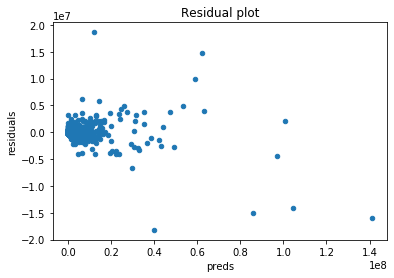

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


FOLD2     RMSE-724143.22


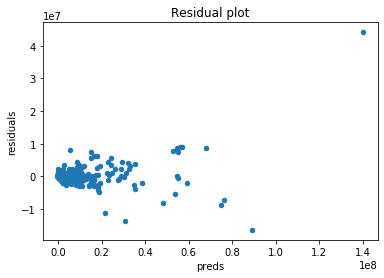

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


FOLD3     RMSE-608737.95


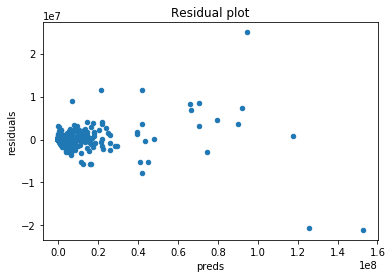

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


FOLD4     RMSE-551559.15


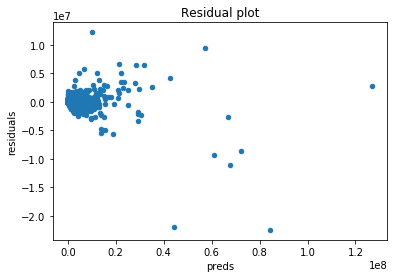

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


FOLD5     RMSE-450258.30


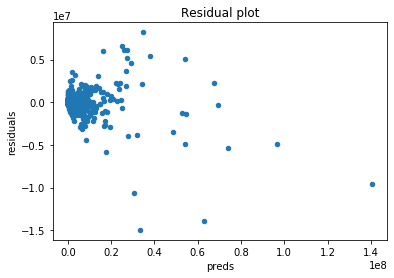

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


FOLD6     RMSE-535064.24


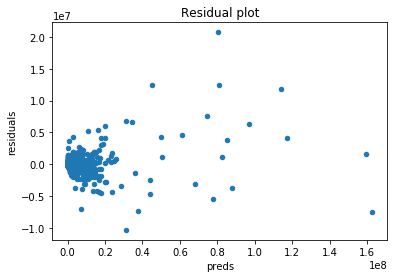

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


FOLD7     RMSE-631116.40


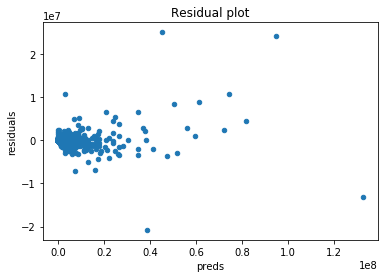

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


FOLD8     RMSE-538159.30


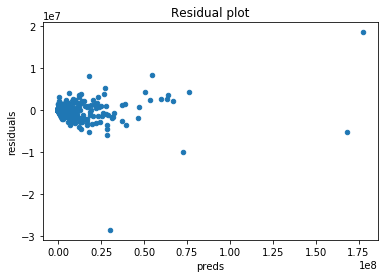

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


FOLD9     RMSE-361287.51


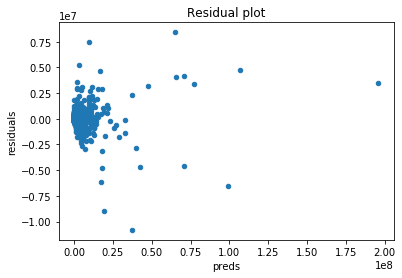

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


FOLD10    RMSE-578638.63


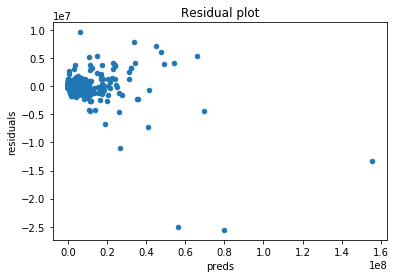

CV score is 562898.9262368988
CPU times: user 16min 1s, sys: 1min 20s, total: 17min 21s
Wall time: 5min 31s


In [14]:
%%time
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

kf=KFold(n_splits=10)

# train_prediction = []
test_prediction = []
valid_prediction = []
valid_true = []
sel_cols = _predictors.copy()

residual_df = pd.DataFrame()
for i, (train_index, test_index) in enumerate(kf.split(train)):
    X_train = train.iloc[train_index]
    X_valid = train.iloc[test_index]
    X_test = test.copy()
    
    from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
    from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder
    from sklearn.pipeline import Pipeline

    def get_clf_pipeline(): 
        steps = [('Impute', Imputer(strategy='median')),
                 ('scaler', StandardScaler())]
        return Pipeline(steps)

    y_train = X_train['Views']
    y_valid = X_valid['Views']
    
    pipeline = get_clf_pipeline()
    X_train = pipeline.fit_transform(X_train[sel_cols])
    X_valid = pipeline.transform(X_valid[sel_cols])
    X_test = pipeline.transform(X_test[sel_cols])

    model = RidgeCV()
    model.fit(X_train, y_train)
    prediction = model.predict(X_train)

    prediction = model.predict(X_valid)
    prediction = np.clip(prediction,0,None)
    valid_prediction.extend(prediction)
    valid_true.extend(y_valid.values)
    print('FOLD{:<5} RMSE-{:0.2f}'.format(i+1, np.sqrt(mean_squared_error(y_valid, prediction))))
    
    # matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
    preds = pd.DataFrame({"fold":i+1, "preds": prediction, "true": y_valid})
    preds["residuals"] = preds["true"] - preds["preds"]
    preds.plot(x = "preds", y = "residuals",kind = "scatter")
    plt.title("Residual plot")
    plt.show()
    
    residual_df = pd.concat((residual_df, preds), axis=0)
    
    prediction = model.predict(X_test)
    prediction = np.clip(prediction,0,None)
    test_prediction.append(prediction)

# print(np.sqrt(mean_squared_error(np.expm1(valid_true), np.expm1(valid_prediction))))
print("CV score is {}".format(np.sqrt(mean_squared_error(valid_true, valid_prediction))))

In [36]:
test_prediction = np.mean(test_prediction, axis=0)

In [37]:
submission = pd.DataFrame()
submission['Unique_ID'] = test['Unique_ID']
# submission['Views'] = np.expm1(test_prediction)
submission['Views'] = test_prediction
submission.head()

,Unique_ID,Views
0,562546,231518.364703
1,907584,38773.658269
2,213013,6486.424776
3,340312,58261.433744
4,41854,0.000000


In [38]:
submission.to_excel("baseline_model_v2.xlsx", index=None)